In [1]:
import numpy as np
import xarray as xr
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras import layers
from keras.callbacks import EarlyStopping
import tensorflow as tf
import sklearn, os

from mpl_toolkits import mplot3d

/home/yloukachev/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
dataset_names = {'pCO2': 'pCO2_2D_mon_CESM001_1x1_198201-201701.nc',
                 'XCO2': 'XCO2_1D_mon_CESM001_native_198201-201701.nc',
                 'SST': 'SST_2D_mon_CESM001_1x1_198201-201701.nc',
                 'SSS': 'SSS_2D_mon_CESM001_1x1_198201-201701.nc',
                 'MLD': 'MLD_2D_mon_CESM001_1x1_198201-201701.nc',
                 'Chl': 'Chl_2D_mon_CESM001_1x1_198201-201701.nc'}

ds = {}
for dataset in dataset_names.keys():
    filename = os.path.join(dataset_names[dataset])
    ds[dataset] = xr.open_dataset(filename)

In [3]:
merged_dataset = xr.merge([ds[name][name] for name in ds.keys()])
df = merged_dataset.to_dataframe().reset_index()

df.dropna(subset=['xlon', 'ylat','pCO2', 'XCO2', 'SST', 'SSS', 'MLD', 'Chl'], inplace=True)
shift_param = int(df.shape[0]/df['time'].nunique())

df['A'], df['B'], df['C'] = np.sin(df['ylat']), np.sin(df['xlon'])*np.cos(df['ylat']), -np.cos(df['xlon'])*np.cos(df['ylat'])
df['T0'] = np.cos(df.time.dt.dayofyear * 2 * np.pi / 365)
df['T1'] = np.sin(df.time.dt.dayofyear * 2 * np.pi / 365)
df['month'], df['year'] = df.time.dt.month, df.time.dt.year

df.drop(columns=['time', 'TLONG', 'TLAT'], inplace=True)

df['pCO2'] = df.pop('pCO2')
df.head()

,xlon,ylat,XCO2,SST,SSS,MLD,Chl,A,B,C,T0,T1,month,year,pCO2
20,0.5,-69.5,340.848541,-1.552322,33.641834,12.729663,1.128493,-0.375524,0.444338,-0.813355,0.962309,0.271958,1,1982,256.390077
21,0.5,-68.5,340.848541,-1.626047,33.667816,19.951666,0.900315,0.576990,0.391571,-0.716767,0.962309,0.271958,1,1982,262.338616
22,0.5,-67.5,340.848541,-1.607591,33.572289,19.510101,0.635458,0.999021,-0.021204,0.038813,0.962309,0.271958,1,1982,261.956626
23,0.5,-66.5,340.848541,-1.496069,33.424641,20.714338,0.420227,0.502557,-0.414484,0.758709,0.962309,0.271958,1,1982,262.739347
24,0.5,-65.5,340.848541,-1.207762,33.317802,20.579535,0.380468,-0.455956,-0.426690,0.781051,0.962309,0.271958,1,1982,266.288585


In [4]:
def train_test_split_SOM(df, num_clusters, test_split=0.2):
    
    cluster_type = 'k=' + str(num_clusters)
    clusters_to_drop = [col for col in df.columns if 'k=' in col]
    
    try:
        clusters_to_drop.remove(cluster_type)
    except ValueError:
        raise ValueError('Invalid cluster assignment.')
    
    # drop unnecessary clusters types
    df_cluster = df.drop(columns=clusters_to_drop)
    
    # creating a unique dataframe for each cluster
    df_dict = {}
    for k in df_cluster[cluster_type].unique():
        df_dict['df{0}'.format(k)] = df_cluster[df_cluster[cluster_type] == k].drop(columns=cluster_type)

    # creating a unique feature and target matrix for each cluster
    X_dict, y_dict = {}, {}
    for key, value in df_dict.items():
        X_dict['X{0}'.format(key[-1])] = value.values[:, :-1]
        y_dict['y{0}'.format(key[-1])] = value.values[:, -1:]

    # creating a unique train/test split for each feature/target mapping
    train_X_dict, test_X_dict, train_y_dict, test_y_dict = {}, {}, {}, {}
    for i in range(0, num_clusters):
        train_X_dict[i], test_X_dict[i], train_y_dict[i], test_y_dict[i] = train_test_split(X_dict['X{0}'.format(i)], y_dict['y{0}'.format(i)], test_size=test_split, shuffle=False)
        
    return train_X_dict, test_X_dict, train_y_dict, test_y_dict

In [ ]:
def FFN_Model():
    model = Sequential()
    
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(1024, activation='relu', kernel_initializer='glorot_normal'))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(512, activation='relu', kernel_initializer='glorot_normal'))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(1, kernel_initializer='glorot_normal'))
    
    model.compile(optimizer='adam', loss='mse', metrics=['mse'])
    return model

In [ ]:
def clusters_as_a_feature(df, num_clusters):
    
    cluster_type = 'k=' + str(num_clusters)
    clusters_to_drop = [col for col in df.columns if 'k=' in col]
    
    if num_clusters == 0:
        df_cluster = df.drop(columns=clusters_to_drop)
    else:
        try:
            clusters_to_drop.remove(cluster_type)
        except ValueError:
            raise ValueError('Invalid cluster assignment.')

        df_cluster = df.drop(columns=clusters_to_drop)
        df_cluster = pd.get_dummies(df_cluster, columns=[cluster_type])
    
    df_cluster.drop(columns=['logMLD', 'day', 'time', 'month', 'year', 'ylat', 'xlon'], inplace=True)
    df_cluster['pCO2'] = df_cluster.pop('pCO2')
    
    values = df_cluster.values
    n_train_months = int(df_cluster.shape[0] * .8)

    train = values[:n_train_months, :]
    test = values[n_train_months:, :]

    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    
    return train_X, train_y, test_X, test_y

## Baseline Feedforward Neural Network

In [ ]:
df.drop(columns=['ylat', 'xlon'], inplace=True)

values = df.values
n_train_months = shift_param * 12 * 30 # training on 30 years and evaluating on five years

train = values[:n_train_months, :]
test = values[n_train_months:, :]

train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

In [5]:
model = tf.keras.models.Sequential([
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1024, activation=tf.nn.relu, kernel_initializer='glorot_normal'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(512, activation=tf.nn.relu, kernel_initializer='glorot_normal'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, kernel_initializer='normal')])

model.compile(optimizer='rmsprop', loss='mean_squared_error', metrics=['mse'])

In [ ]:
history = model.fit(train_X, train_y, epochs=100, batch_size=1024, validation_data=(test_X, test_y))

In [ ]:
mse = history.history['mean_squared_error']
val_mse = history.history['val_mean_squared_error']

epochs = range(1, len(mse) + 1)

plt.figure()
plt.plot(epochs, mse, 'r', label='Training MSE')
plt.plot(epochs, val_mse, 'b', label='Validation MSE')
plt.title('Training and validation MSE')
plt.legend()

plt.show()

In [ ]:
model.save_weights('baseline_DNN.h5')

## Extrapolated SOM Clusters as Input to FFN

In [4]:
merged_dataset = xr.merge([ds[name][name] for name in ds.keys()])
df = merged_dataset.to_dataframe().reset_index()

df.dropna(subset=['xlon', 'ylat','pCO2', 'XCO2', 'SST', 'SSS', 'MLD', 'Chl'], inplace=True)
shift_param = int(df.shape[0]/df['time'].nunique())

df['A'], df['B'], df['C'] = np.sin(df['ylat']), np.sin(df['xlon'])*np.cos(df['ylat']), -np.cos(df['xlon'])*np.cos(df['ylat'])
df['T0'] = np.cos(df.time.dt.dayofyear * 2 * np.pi / 365)
df['T1'] = np.sin(df.time.dt.dayofyear * 2 * np.pi / 365)

df.drop(columns=['time', 'TLONG', 'TLAT'], inplace=True)

df['pCO2'] = df.pop('pCO2')

In [5]:
SOM_df = pd.read_csv('means_SOM.csv', index_col=0)
SOM_df.reset_index(drop=True, inplace=True)
df.reset_index(drop=True, inplace=True)

SOM_df = pd.merge(df, SOM_df[['ylat', 'xlon', 'k=5', 'k=10', 'k=15']], how='inner', left_on=['ylat', 'xlon'], right_on=['ylat', 'xlon'])

SOM_df['A'], SOM_df['B'], SOM_df['C'] = np.sin(SOM_df['ylat']), np.sin(SOM_df['xlon'])*np.cos(SOM_df['ylat']), -np.cos(SOM_df['xlon'])*np.cos(SOM_df['ylat'])
SOM_df.drop(columns=['ylat', 'xlon'], inplace=True)

SOM_df['pCO2'] = SOM_df.pop('pCO2')
SOM_df.head()

,XCO2,SST,SSS,MLD,Chl,A,B,C,T0,T1,k=5,k=10,k=15,pCO2
0,340.848541,-1.552322,33.641834,12.729663,1.128493,-0.375524,0.444338,-0.813355,0.962309,0.271958,3,0,7,256.390077
1,340.962250,-1.643371,33.400482,22.005390,0.064728,-0.375524,0.444338,-0.813355,0.702527,0.711657,3,0,7,259.943180
2,341.075439,-1.800755,33.382126,38.298309,0.115517,-0.375524,0.444338,-0.813355,0.276097,0.961130,3,0,7,271.485986
3,341.193176,-1.816007,33.603302,65.371696,0.062877,-0.375524,0.444338,-0.813355,-0.251190,0.967938,3,0,7,286.451083
4,341.310730,-1.814708,33.780853,83.675964,0.036665,-0.375524,0.444338,-0.813355,-0.696376,0.717677,3,0,7,300.785596


In [27]:
clusters = 5

train_X, test_X, train_y, test_y = train_test_split_SOM(SOM_df, clusters)

In [ ]:
history_dict = {}

for k in range(clusters):
    model = FFN_Model()

    history_dict['history_{}'.format(k)] = model.fit(train_X[k], train_y[k], validation_data=(test_X[k], test_y[k]), batch_size=1024, epochs=100)

In [ ]:
mse = history.history['mean_squared_error']
val_mse = history.history['val_mean_squared_error']

epochs = range(1, len(mse) + 1)

plt.figure()
plt.plot(epochs, mse, 'bo', label='Training MSE')
plt.plot(epochs, val_mse, 'b', label='Validation MSE')
plt.title('Training and validation MSE')
plt.legend()

plt.show()

## Mean SOM Clusters as Input to FFN

In [ ]:
merged_dataset = xr.merge([ds[name][name] for name in ds.keys()])
df = merged_dataset.to_dataframe().reset_index()

df.dropna(subset=['xlon', 'ylat','pCO2', 'XCO2', 'SST', 'SSS', 'MLD', 'Chl'], inplace=True)
shift_param = int(df.shape[0]/df['time'].nunique())

df['A'], df['B'], df['C'] = np.sin(df['ylat']), np.sin(df['xlon'])*np.cos(df['ylat']), -np.cos(df['xlon'])*np.cos(df['ylat'])
df['T0'] = np.cos(df.time.dt.dayofyear * 2 * np.pi / 365)
df['T1'] = np.sin(df.time.dt.dayofyear * 2 * np.pi / 365)

df.drop(columns=['time', 'TLONG', 'TLAT'], inplace=True)

df['pCO2'] = df.pop('pCO2')

In [ ]:
SOM_df = pd.read_csv('means_SOM.csv', index_col=0) # input file for monthly SOM clusters

SOM_df['A'], SOM_df['B'], SOM_df['C'] = np.sin(SOM_df['ylat']), np.sin(SOM_df['xlon'])*np.cos(SOM_df['ylat']), -np.cos(SOM_df['xlon'])*np.cos(SOM_df['ylat'])
SOM_df.drop(columns=['ylat', 'xlon'], inplace=True)

SOM_df['pCO2'] = SOM_df.pop('pCO2')
SOM_df.head()

In [ ]:
clusters = 5

train_X, test_X, train_y, test_y = train_test_split_SOM(SOM_df, clusters)

In [ ]:
history_dict = {}

for k in range(clusters):
    model = FFN_Model()

    history_dict['history_{}'.format(k)] = model.fit(train_X[k], train_y[k], validation_data=(test_X[k], test_y[k]), batch_size=1024, epochs=500)
    model.save('SOM_FFN_{}.h5'.format(k))

## Clusters as a Feature

In [7]:
SOM_df = pd.read_csv('10%_Sample_w_clusters_63_104.csv', index_col=0).reset_index(drop=True)

SOM_df['day'] = 15
SOM_df['time'] = pd.to_datetime(SOM_df[['day', 'month', 'year']])
SOM_df['A'], SOM_df['B'], SOM_df['C'] = np.sin(SOM_df['ylat']), np.sin(SOM_df['xlon'])*np.cos(SOM_df['ylat']), -np.cos(SOM_df['xlon'])*np.cos(SOM_df['ylat'])
SOM_df['T0'] = np.cos(SOM_df.time.dt.dayofyear * 2 * np.pi / 365)
SOM_df['T1'] = np.sin(SOM_df.time.dt.dayofyear * 2 * np.pi / 365)

SOM_df = pd.merge(SOM_df, df[['ylat', 'xlon', 'month', 'year', 'Chl', 'XCO2']], how='inner', left_on=['ylat', 'xlon', 'month', 'year'], right_on=['ylat', 'xlon', 'month', 'year'])

In [22]:
# k = 10
train_X, train_y, test_X, test_y = clusters_as_a_feature(SOM_df, 10)

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

model = FFN_Model()
history = model.fit(train_X, train_y, validation_data=(test_X, test_y), batch_size=1024, epochs=500)

(1382059, 20) (1382059,) (345515, 20) (345515,)
Train on 1382059 samples, validate on 345515 samples
Epoch 1/500
1382059/1382059 [==============================] - 15s 11us/step - loss: 3843.4953 - mean_squared_error: 3843.4953 - val_loss: 502.3236 - val_mean_squared_error: 502.3236
Epoch 2/500
1382059/1382059 [==============================] - 14s 10us/step - loss: 979.1357 - mean_squared_error: 979.1357 - val_loss: 470.5890 - val_mean_squared_error: 470.5890
Epoch 3/500
1382059/1382059 [==============================] - 13s 10us/step - loss: 931.4160 - mean_squared_error: 931.4160 - val_loss: 463.1146 - val_mean_squared_error: 463.1146
Epoch 4/500
1382059/1382059 [==============================] - 14s 10us/step - loss: 907.1127 - mean_squared_error: 907.1127 - val_loss: 448.5367 - val_mean_squared_error: 448.5367
Epoch 5/500
1382059/1382059 [==============================] - 14s 10us/step - loss: 892.7416 - mean_squared_error: 892.7416 - val_loss: 433.7817 - val_mean_squared_error: 4

1382059/1382059 [==============================] - 13s 10us/step - loss: 455.5664 - mean_squared_error: 455.5664 - val_loss: 184.6487 - val_mean_squared_error: 184.6487
Epoch 91/500
1382059/1382059 [==============================] - 14s 10us/step - loss: 453.9009 - mean_squared_error: 453.9009 - val_loss: 182.9043 - val_mean_squared_error: 182.9043
Epoch 92/500
1382059/1382059 [==============================] - 13s 10us/step - loss: 452.9158 - mean_squared_error: 452.9158 - val_loss: 185.8708 - val_mean_squared_error: 185.8708
Epoch 93/500
1382059/1382059 [==============================] - 13s 10us/step - loss: 451.5871 - mean_squared_error: 451.5871 - val_loss: 181.4780 - val_mean_squared_error: 181.4780
Epoch 94/500
1382059/1382059 [==============================] - 13s 10us/step - loss: 449.7756 - mean_squared_error: 449.7756 - val_loss: 184.2817 - val_mean_squared_error: 184.2817
Epoch 95/500
1382059/1382059 [==============================] - 13s 10us/step - loss: 450.2834 - mean_s

Epoch 135/500
1382059/1382059 [==============================] - 13s 10us/step - loss: 407.7554 - mean_squared_error: 407.7554 - val_loss: 171.4468 - val_mean_squared_error: 171.4468
Epoch 136/500
1382059/1382059 [==============================] - 13s 10us/step - loss: 406.7684 - mean_squared_error: 406.7684 - val_loss: 174.8416 - val_mean_squared_error: 174.8416
Epoch 137/500
1382059/1382059 [==============================] - 13s 10us/step - loss: 406.7207 - mean_squared_error: 406.7207 - val_loss: 172.5598 - val_mean_squared_error: 172.5598
Epoch 138/500
1382059/1382059 [==============================] - 13s 10us/step - loss: 404.6520 - mean_squared_error: 404.6520 - val_loss: 183.9671 - val_mean_squared_error: 183.9671
Epoch 139/500
1382059/1382059 [==============================] - 13s 10us/step - loss: 403.6739 - mean_squared_error: 403.6739 - val_loss: 170.0573 - val_mean_squared_error: 170.0573
Epoch 140/500
1382059/1382059 [==============================] - 13s 10us/step - loss

Epoch 180/500
1382059/1382059 [==============================] - 13s 10us/step - loss: 369.1838 - mean_squared_error: 369.1838 - val_loss: 165.0191 - val_mean_squared_error: 165.0191
Epoch 181/500
1382059/1382059 [==============================] - 13s 10us/step - loss: 368.6714 - mean_squared_error: 368.6714 - val_loss: 165.5704 - val_mean_squared_error: 165.5704
Epoch 182/500
1382059/1382059 [==============================] - 13s 10us/step - loss: 367.3969 - mean_squared_error: 367.3969 - val_loss: 167.8359 - val_mean_squared_error: 167.8359
Epoch 183/500
1382059/1382059 [==============================] - 13s 10us/step - loss: 367.5600 - mean_squared_error: 367.5600 - val_loss: 163.9430 - val_mean_squared_error: 163.9430
Epoch 184/500
1382059/1382059 [==============================] - 13s 10us/step - loss: 366.7760 - mean_squared_error: 366.7760 - val_loss: 167.7985 - val_mean_squared_error: 167.7985
Epoch 185/500
1382059/1382059 [==============================] - 13s 10us/step - loss

Epoch 225/500
1382059/1382059 [==============================] - 13s 10us/step - loss: 337.3462 - mean_squared_error: 337.3462 - val_loss: 162.8146 - val_mean_squared_error: 162.8146
Epoch 226/500
1382059/1382059 [==============================] - 13s 10us/step - loss: 337.9331 - mean_squared_error: 337.9331 - val_loss: 162.8090 - val_mean_squared_error: 162.8090
Epoch 227/500
1382059/1382059 [==============================] - 13s 10us/step - loss: 335.4777 - mean_squared_error: 335.4777 - val_loss: 163.8012 - val_mean_squared_error: 163.8012
Epoch 228/500
1382059/1382059 [==============================] - 13s 10us/step - loss: 335.4595 - mean_squared_error: 335.4595 - val_loss: 160.7904 - val_mean_squared_error: 160.7904
Epoch 229/500
1382059/1382059 [==============================] - 13s 10us/step - loss: 335.1407 - mean_squared_error: 335.1407 - val_loss: 162.6079 - val_mean_squared_error: 162.6079
Epoch 230/500
1382059/1382059 [==============================] - 13s 10us/step - loss

Epoch 270/500
1382059/1382059 [==============================] - 14s 10us/step - loss: 310.4457 - mean_squared_error: 310.4457 - val_loss: 162.5062 - val_mean_squared_error: 162.5062
Epoch 271/500
1382059/1382059 [==============================] - 13s 10us/step - loss: 309.8417 - mean_squared_error: 309.8417 - val_loss: 161.5420 - val_mean_squared_error: 161.5420
Epoch 272/500
1382059/1382059 [==============================] - 13s 10us/step - loss: 309.9661 - mean_squared_error: 309.9661 - val_loss: 161.4463 - val_mean_squared_error: 161.4463
Epoch 273/500
1382059/1382059 [==============================] - 13s 10us/step - loss: 309.6872 - mean_squared_error: 309.6872 - val_loss: 164.3452 - val_mean_squared_error: 164.3452
Epoch 274/500
1382059/1382059 [==============================] - 14s 10us/step - loss: 308.7089 - mean_squared_error: 308.7089 - val_loss: 160.8735 - val_mean_squared_error: 160.8735
Epoch 275/500
1382059/1382059 [==============================] - 13s 10us/step - loss

Epoch 315/500
1382059/1382059 [==============================] - 14s 10us/step - loss: 289.2163 - mean_squared_error: 289.2163 - val_loss: 164.3171 - val_mean_squared_error: 164.3171
Epoch 316/500
1382059/1382059 [==============================] - 14s 10us/step - loss: 288.6058 - mean_squared_error: 288.6058 - val_loss: 156.1014 - val_mean_squared_error: 156.1014
Epoch 317/500
1382059/1382059 [==============================] - 14s 10us/step - loss: 289.0743 - mean_squared_error: 289.0743 - val_loss: 159.4707 - val_mean_squared_error: 159.4707
Epoch 318/500
1382059/1382059 [==============================] - 14s 10us/step - loss: 288.2257 - mean_squared_error: 288.2257 - val_loss: 155.3579 - val_mean_squared_error: 155.3579
Epoch 319/500
1382059/1382059 [==============================] - 14s 10us/step - loss: 287.5344 - mean_squared_error: 287.5344 - val_loss: 159.4637 - val_mean_squared_error: 159.4637
Epoch 320/500
1382059/1382059 [==============================] - 14s 10us/step - loss

Epoch 360/500
1382059/1382059 [==============================] - 14s 10us/step - loss: 270.0194 - mean_squared_error: 270.0194 - val_loss: 155.1369 - val_mean_squared_error: 155.1369
Epoch 361/500
1382059/1382059 [==============================] - 14s 10us/step - loss: 269.9706 - mean_squared_error: 269.9706 - val_loss: 157.2063 - val_mean_squared_error: 157.2063
Epoch 362/500
1382059/1382059 [==============================] - 14s 10us/step - loss: 269.7755 - mean_squared_error: 269.7755 - val_loss: 155.9941 - val_mean_squared_error: 155.9941
Epoch 363/500
1382059/1382059 [==============================] - 14s 10us/step - loss: 268.7378 - mean_squared_error: 268.7378 - val_loss: 154.0370 - val_mean_squared_error: 154.0370
Epoch 364/500
1382059/1382059 [==============================] - 14s 10us/step - loss: 269.8122 - mean_squared_error: 269.8122 - val_loss: 152.7698 - val_mean_squared_error: 152.7698
Epoch 365/500
1382059/1382059 [==============================] - 14s 10us/step - loss

Epoch 405/500
1382059/1382059 [==============================] - 14s 10us/step - loss: 255.7385 - mean_squared_error: 255.7385 - val_loss: 156.0078 - val_mean_squared_error: 156.0078
Epoch 406/500
1382059/1382059 [==============================] - 14s 10us/step - loss: 254.3028 - mean_squared_error: 254.3028 - val_loss: 151.5191 - val_mean_squared_error: 151.5191
Epoch 407/500
1382059/1382059 [==============================] - 14s 10us/step - loss: 255.4323 - mean_squared_error: 255.4323 - val_loss: 156.5108 - val_mean_squared_error: 156.5108
Epoch 408/500
1382059/1382059 [==============================] - 14s 10us/step - loss: 253.8677 - mean_squared_error: 253.8677 - val_loss: 152.9375 - val_mean_squared_error: 152.9375
Epoch 409/500
1382059/1382059 [==============================] - 14s 10us/step - loss: 253.4858 - mean_squared_error: 253.4858 - val_loss: 150.7176 - val_mean_squared_error: 150.7176
Epoch 410/500
1382059/1382059 [==============================] - 14s 10us/step - loss

Epoch 450/500
1382059/1382059 [==============================] - 14s 10us/step - loss: 241.2253 - mean_squared_error: 241.2253 - val_loss: 152.9894 - val_mean_squared_error: 152.9894
Epoch 451/500
1382059/1382059 [==============================] - 14s 10us/step - loss: 242.0566 - mean_squared_error: 242.0566 - val_loss: 150.6060 - val_mean_squared_error: 150.6060
Epoch 452/500
1382059/1382059 [==============================] - 14s 10us/step - loss: 241.6317 - mean_squared_error: 241.6317 - val_loss: 149.2578 - val_mean_squared_error: 149.2578
Epoch 453/500
1382059/1382059 [==============================] - 14s 10us/step - loss: 241.2572 - mean_squared_error: 241.2572 - val_loss: 153.0462 - val_mean_squared_error: 153.0462
Epoch 454/500
1382059/1382059 [==============================] - 14s 10us/step - loss: 240.6523 - mean_squared_error: 240.6523 - val_loss: 154.2685 - val_mean_squared_error: 154.2685
Epoch 455/500
1382059/1382059 [==============================] - 14s 10us/step - loss

Epoch 495/500
1382059/1382059 [==============================] - 14s 10us/step - loss: 231.7256 - mean_squared_error: 231.7256 - val_loss: 152.2093 - val_mean_squared_error: 152.2093
Epoch 496/500
1382059/1382059 [==============================] - 14s 10us/step - loss: 231.1237 - mean_squared_error: 231.1237 - val_loss: 148.9137 - val_mean_squared_error: 148.9137
Epoch 497/500
1382059/1382059 [==============================] - 14s 10us/step - loss: 231.2442 - mean_squared_error: 231.2442 - val_loss: 149.9320 - val_mean_squared_error: 149.9320
Epoch 498/500
1382059/1382059 [==============================] - 14s 10us/step - loss: 230.7681 - mean_squared_error: 230.7681 - val_loss: 149.0214 - val_mean_squared_error: 149.0214
Epoch 499/500
1382059/1382059 [==============================] - 14s 10us/step - loss: 230.8110 - mean_squared_error: 230.8110 - val_loss: 150.2865 - val_mean_squared_error: 150.2865
Epoch 500/500
1382059/1382059 [==============================] - 14s 10us/step - loss

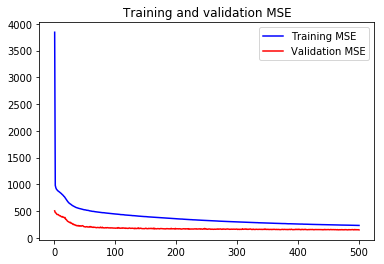

Average validation RMSE:  12.227781746014053


In [23]:
mse = history.history['mean_squared_error']
val_mse = history.history['val_mean_squared_error']

epochs = range(1, len(mse) + 1)

plt.figure()
plt.plot(epochs, mse, 'b', label='Training MSE')
plt.plot(epochs, val_mse, 'r', label='Validation MSE')
plt.title('Training and validation MSE')
plt.legend()

plt.show()

avg_val_mse = np.mean(history.history['val_loss'][-10:])
print('Average validation RMSE: ', np.sqrt(avg_val_mse))

In [18]:
# k = 15
train_X, train_y, test_X, test_y = clusters_as_a_feature(SOM_df, 15)

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

model = FFN_Model()
history = model.fit(train_X, train_y, validation_data=(test_X, test_y), batch_size=1024, epochs=250)

(1382059, 25) (1382059,) (345515, 25) (345515,)
Train on 1382059 samples, validate on 345515 samples
Epoch 1/250
1382059/1382059 [==============================] - 15s 11us/step - loss: 3650.4634 - mean_squared_error: 3650.4634 - val_loss: 498.9363 - val_mean_squared_error: 498.9363
Epoch 2/250
1382059/1382059 [==============================] - 15s 11us/step - loss: 943.1969 - mean_squared_error: 943.1969 - val_loss: 466.7299 - val_mean_squared_error: 466.7299
Epoch 3/250
1382059/1382059 [==============================] - 15s 11us/step - loss: 902.8474 - mean_squared_error: 902.8474 - val_loss: 453.9861 - val_mean_squared_error: 453.9861
Epoch 4/250
1382059/1382059 [==============================] - 15s 11us/step - loss: 887.3199 - mean_squared_error: 887.3199 - val_loss: 453.4833 - val_mean_squared_error: 453.4833
Epoch 5/250
1382059/1382059 [==============================] - 14s 10us/step - loss: 874.0982 - mean_squared_error: 874.0982 - val_loss: 445.0696 - val_mean_squared_error: 4

1382059/1382059 [==============================] - 14s 10us/step - loss: 469.2527 - mean_squared_error: 469.2527 - val_loss: 209.1193 - val_mean_squared_error: 209.1193
Epoch 91/250
1382059/1382059 [==============================] - 14s 10us/step - loss: 466.7485 - mean_squared_error: 466.7485 - val_loss: 203.1431 - val_mean_squared_error: 203.1431
Epoch 92/250
1382059/1382059 [==============================] - 14s 10us/step - loss: 465.7082 - mean_squared_error: 465.7082 - val_loss: 205.3528 - val_mean_squared_error: 205.3528
Epoch 93/250
1382059/1382059 [==============================] - 14s 10us/step - loss: 464.3375 - mean_squared_error: 464.3375 - val_loss: 196.9055 - val_mean_squared_error: 196.9055
Epoch 94/250
1382059/1382059 [==============================] - 14s 10us/step - loss: 462.2858 - mean_squared_error: 462.2858 - val_loss: 202.5743 - val_mean_squared_error: 202.5743
Epoch 95/250
1382059/1382059 [==============================] - 14s 10us/step - loss: 460.5277 - mean_s

Epoch 135/250
1382059/1382059 [==============================] - 14s 10us/step - loss: 411.5128 - mean_squared_error: 411.5128 - val_loss: 180.5711 - val_mean_squared_error: 180.5711
Epoch 136/250
1382059/1382059 [==============================] - 14s 10us/step - loss: 411.2903 - mean_squared_error: 411.2903 - val_loss: 177.5033 - val_mean_squared_error: 177.5033
Epoch 137/250
1382059/1382059 [==============================] - 14s 10us/step - loss: 409.0121 - mean_squared_error: 409.0121 - val_loss: 182.4480 - val_mean_squared_error: 182.4480
Epoch 138/250
1382059/1382059 [==============================] - 14s 10us/step - loss: 408.9012 - mean_squared_error: 408.9012 - val_loss: 180.3656 - val_mean_squared_error: 180.3656
Epoch 139/250
1382059/1382059 [==============================] - 14s 10us/step - loss: 407.5079 - mean_squared_error: 407.5079 - val_loss: 176.7074 - val_mean_squared_error: 176.7074
Epoch 140/250
1382059/1382059 [==============================] - 14s 10us/step - loss

Epoch 180/250
1382059/1382059 [==============================] - 14s 10us/step - loss: 374.8992 - mean_squared_error: 374.8992 - val_loss: 172.1494 - val_mean_squared_error: 172.1494
Epoch 181/250
1382059/1382059 [==============================] - 14s 10us/step - loss: 373.2957 - mean_squared_error: 373.2957 - val_loss: 173.6205 - val_mean_squared_error: 173.6205
Epoch 182/250
1382059/1382059 [==============================] - 14s 10us/step - loss: 371.6075 - mean_squared_error: 371.6075 - val_loss: 171.7863 - val_mean_squared_error: 171.7863
Epoch 183/250
1382059/1382059 [==============================] - 14s 10us/step - loss: 370.6681 - mean_squared_error: 370.6681 - val_loss: 173.8680 - val_mean_squared_error: 173.8680
Epoch 184/250
1382059/1382059 [==============================] - 14s 10us/step - loss: 370.0494 - mean_squared_error: 370.0494 - val_loss: 166.1070 - val_mean_squared_error: 166.1070
Epoch 185/250
1382059/1382059 [==============================] - 14s 10us/step - loss

Epoch 225/250
1382059/1382059 [==============================] - 14s 10us/step - loss: 343.1418 - mean_squared_error: 343.1418 - val_loss: 165.1297 - val_mean_squared_error: 165.1297
Epoch 226/250
1382059/1382059 [==============================] - 14s 10us/step - loss: 341.8254 - mean_squared_error: 341.8254 - val_loss: 170.8955 - val_mean_squared_error: 170.8955
Epoch 227/250
1382059/1382059 [==============================] - 14s 10us/step - loss: 339.6734 - mean_squared_error: 339.6734 - val_loss: 164.8502 - val_mean_squared_error: 164.8502
Epoch 228/250
1382059/1382059 [==============================] - 14s 10us/step - loss: 340.4455 - mean_squared_error: 340.4455 - val_loss: 169.8915 - val_mean_squared_error: 169.8915
Epoch 229/250
1382059/1382059 [==============================] - 14s 10us/step - loss: 339.0048 - mean_squared_error: 339.0048 - val_loss: 174.1479 - val_mean_squared_error: 174.1479
Epoch 230/250
1382059/1382059 [==============================] - 14s 10us/step - loss

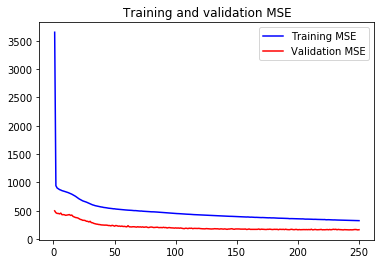

Average validation RMSE:  12.886353186026799


In [19]:
mse = history.history['mean_squared_error']
val_mse = history.history['val_mean_squared_error']

epochs = range(1, len(mse) + 1)

plt.figure()
plt.plot(epochs, mse, 'b', label='Training MSE')
plt.plot(epochs, val_mse, 'r', label='Validation MSE')
plt.title('Training and validation MSE')
plt.legend()

plt.show()

avg_val_mse = np.mean(history.history['val_loss'][-10:])
print('Average validation RMSE: ', np.sqrt(avg_val_mse))

In [63]:
# baseline (no clusters)
train_X, train_y, test_X, test_y = clusters_as_a_feature(SOM_df, 15)

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

model = FFN_Model()
history = model.fit(train_X, train_y, validation_data=(test_X, test_y), batch_size=1024, epochs=250)

Train on 1382059 samples, validate on 345515 samples
Epoch 1/250
1382059/1382059 [==============================] - 18s 13us/step - loss: 3682.4143 - mean_squared_error: 3682.4143 - val_loss: 480.5237 - val_mean_squared_error: 480.5237
Epoch 2/250
1382059/1382059 [==============================] - 17s 12us/step - loss: 932.6175 - mean_squared_error: 932.6175 - val_loss: 443.5706 - val_mean_squared_error: 443.5706
Epoch 3/250
1382059/1382059 [==============================] - 16s 12us/step - loss: 889.6514 - mean_squared_error: 889.6514 - val_loss: 437.5231 - val_mean_squared_error: 437.5231
Epoch 4/250
1382059/1382059 [==============================] - 16s 12us/step - loss: 870.9815 - mean_squared_error: 870.9815 - val_loss: 430.7012 - val_mean_squared_error: 430.7012
Epoch 5/250
1382059/1382059 [==============================] - 17s 12us/step - loss: 856.7871 - mean_squared_error: 856.7871 - val_loss: 417.8662 - val_mean_squared_error: 417.8662
Epoch 6/250
1382059/1382059 [===========

Epoch 46/250
1382059/1382059 [==============================] - 16s 12us/step - loss: 522.3841 - mean_squared_error: 522.3841 - val_loss: 218.4424 - val_mean_squared_error: 218.4424
Epoch 47/250
1382059/1382059 [==============================] - 16s 12us/step - loss: 521.1265 - mean_squared_error: 521.1265 - val_loss: 210.5167 - val_mean_squared_error: 210.5167
Epoch 48/250
1382059/1382059 [==============================] - 16s 12us/step - loss: 518.4938 - mean_squared_error: 518.4938 - val_loss: 209.0077 - val_mean_squared_error: 209.0077
Epoch 49/250
1382059/1382059 [==============================] - 16s 12us/step - loss: 516.7848 - mean_squared_error: 516.7848 - val_loss: 213.0313 - val_mean_squared_error: 213.0313
Epoch 50/250
1382059/1382059 [==============================] - 16s 11us/step - loss: 513.6351 - mean_squared_error: 513.6351 - val_loss: 205.8201 - val_mean_squared_error: 205.8201
Epoch 51/250
1382059/1382059 [==============================] - 16s 11us/step - loss: 511.

1382059/1382059 [==============================] - 16s 11us/step - loss: 452.9745 - mean_squared_error: 452.9745 - val_loss: 185.9197 - val_mean_squared_error: 185.9197
Epoch 92/250
1382059/1382059 [==============================] - 15s 11us/step - loss: 452.3475 - mean_squared_error: 452.3475 - val_loss: 185.2267 - val_mean_squared_error: 185.2267
Epoch 93/250
1382059/1382059 [==============================] - 15s 11us/step - loss: 449.8277 - mean_squared_error: 449.8277 - val_loss: 181.0486 - val_mean_squared_error: 181.0486
Epoch 94/250
1382059/1382059 [==============================] - 16s 11us/step - loss: 449.2991 - mean_squared_error: 449.2991 - val_loss: 185.9695 - val_mean_squared_error: 185.9695
Epoch 95/250
1382059/1382059 [==============================] - 15s 11us/step - loss: 448.6835 - mean_squared_error: 448.6835 - val_loss: 183.7116 - val_mean_squared_error: 183.7116
Epoch 96/250
1382059/1382059 [==============================] - 15s 11us/step - loss: 446.5194 - mean_s

Epoch 136/250
1382059/1382059 [==============================] - 16s 11us/step - loss: 404.1284 - mean_squared_error: 404.1284 - val_loss: 176.6905 - val_mean_squared_error: 176.6905
Epoch 137/250
1382059/1382059 [==============================] - 16s 12us/step - loss: 403.5042 - mean_squared_error: 403.5042 - val_loss: 174.8856 - val_mean_squared_error: 174.8856
Epoch 138/250
1382059/1382059 [==============================] - 16s 12us/step - loss: 402.9906 - mean_squared_error: 402.9906 - val_loss: 172.5668 - val_mean_squared_error: 172.5668
Epoch 139/250
1382059/1382059 [==============================] - 16s 12us/step - loss: 402.9063 - mean_squared_error: 402.9063 - val_loss: 177.1440 - val_mean_squared_error: 177.1440
Epoch 140/250
1382059/1382059 [==============================] - 16s 11us/step - loss: 401.5329 - mean_squared_error: 401.5329 - val_loss: 177.7552 - val_mean_squared_error: 177.7552
Epoch 141/250
1382059/1382059 [==============================] - 17s 12us/step - loss

Epoch 181/250
1382059/1382059 [==============================] - 16s 12us/step - loss: 367.4406 - mean_squared_error: 367.4406 - val_loss: 166.3263 - val_mean_squared_error: 166.3263
Epoch 182/250
1382059/1382059 [==============================] - 16s 12us/step - loss: 366.1768 - mean_squared_error: 366.1768 - val_loss: 168.4771 - val_mean_squared_error: 168.4771
Epoch 183/250
1382059/1382059 [==============================] - 16s 11us/step - loss: 365.9429 - mean_squared_error: 365.9429 - val_loss: 169.7230 - val_mean_squared_error: 169.7230
Epoch 184/250
1382059/1382059 [==============================] - 16s 12us/step - loss: 364.1683 - mean_squared_error: 364.1683 - val_loss: 168.3190 - val_mean_squared_error: 168.3190
Epoch 185/250
1382059/1382059 [==============================] - 16s 11us/step - loss: 362.9293 - mean_squared_error: 362.9293 - val_loss: 168.1550 - val_mean_squared_error: 168.1550
Epoch 186/250
1382059/1382059 [==============================] - 16s 11us/step - loss

Epoch 226/250
1382059/1382059 [==============================] - 15s 11us/step - loss: 336.8828 - mean_squared_error: 336.8828 - val_loss: 167.3572 - val_mean_squared_error: 167.3572
Epoch 227/250
1382059/1382059 [==============================] - 15s 11us/step - loss: 335.0057 - mean_squared_error: 335.0057 - val_loss: 164.4685 - val_mean_squared_error: 164.4685
Epoch 228/250
1382059/1382059 [==============================] - 15s 11us/step - loss: 334.3374 - mean_squared_error: 334.3374 - val_loss: 170.0249 - val_mean_squared_error: 170.0249
Epoch 229/250
1382059/1382059 [==============================] - 15s 11us/step - loss: 334.8443 - mean_squared_error: 334.8443 - val_loss: 162.9402 - val_mean_squared_error: 162.9402
Epoch 230/250
1382059/1382059 [==============================] - 15s 11us/step - loss: 333.2512 - mean_squared_error: 333.2512 - val_loss: 164.1096 - val_mean_squared_error: 164.1096
Epoch 231/250
1382059/1382059 [==============================] - 15s 11us/step - loss

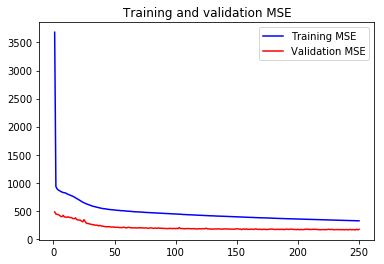

Average validation RMSE:  12.821137846752285


In [64]:
mse = history.history['mean_squared_error']
val_mse = history.history['val_mean_squared_error']

epochs = range(1, len(mse) + 1)

plt.figure()
plt.plot(epochs, mse, 'b', label='Training MSE')
plt.plot(epochs, val_mse, 'r', label='Validation MSE')
plt.title('Training and validation MSE')
plt.legend()

plt.show()

avg_val_mse = np.mean(history.history['val_loss'][-10:])
print('Average validation RMSE: ', np.sqrt(avg_val_mse))

In [65]:
model.save('SOM_15_FFN.h5')

In [5]:
# 100% SOM dataset
SOM_df = pd.read_csv('SOM_all_data.csv', index_col=0).reset_index(drop=True)

SOM_df['day'] = 15
SOM_df['time'] = pd.to_datetime(SOM_df[['day', 'month', 'year']])
SOM_df['A'], SOM_df['B'], SOM_df['C'] = np.sin(SOM_df['ylat']), np.sin(SOM_df['xlon'])*np.cos(SOM_df['ylat']), -np.cos(SOM_df['xlon'])*np.cos(SOM_df['ylat'])
SOM_df['T0'] = np.cos(SOM_df.time.dt.dayofyear * 2 * np.pi / 365)
SOM_df['T1'] = np.sin(SOM_df.time.dt.dayofyear * 2 * np.pi / 365)

SOM_df = pd.merge(SOM_df, df[['ylat', 'xlon', 'month', 'year', 'Chl', 'XCO2']], how='inner', left_on=['ylat', 'xlon', 'month', 'year'], right_on=['ylat', 'xlon', 'month', 'year'])
SOM_df.head()

/home/yloukachev/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,ylat,xlon,SSS,MLD,SST,pCO2,logMLD,month,year,k=5,...,k=15,day,time,A,B,C,T0,T1,Chl,XCO2
0,24.5,145.5,34.516457,34.473396,27.900078,352.818516,3.540188,9,1990,1,...,4,15,1990-09-15,-0.591358,0.672732,-0.444666,-0.267814,-0.963471,0.110500,354.673737
1,-35.5,40.5,34.548840,83.076450,16.368843,312.662032,4.419761,7,1985,3,...,1,15,1985-07-15,0.809019,-0.196408,-0.553997,-0.973118,-0.230306,0.227699,346.094177
2,-65.5,81.5,33.257133,23.466050,2.618722,331.637467,3.155555,2,2007,3,...,10,15,2007-02-15,-0.455956,0.160570,0.875398,0.702527,0.711657,0.119260,383.021515
3,45.5,152.5,32.190420,59.333320,3.973839,328.017932,4.083171,12,1990,1,...,12,15,1990-12-15,0.998591,0.052602,0.007025,0.962309,-0.271958,0.199080,354.964233
4,-42.5,50.5,34.104397,53.165960,13.662021,339.139662,3.973418,4,1990,3,...,10,15,1990-04-15,0.996087,0.020538,-0.085964,-0.234491,0.972118,0.208976,354.186523


In [10]:
# k = 10
train_X, train_y, test_X, test_y = clusters_as_a_feature(SOM_df, 10)

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

model = FFN_Model()
history = model.fit(train_X, train_y, validation_data=(test_X, test_y), batch_size=1024, epochs=100)

(13820588, 20) (13820588,) (3455147, 20) (3455147,)
Train on 13820588 samples, validate on 3455147 samples
Epoch 1/100
13820588/13820588 [==============================] - 143s 10us/step - loss: 1201.5220 - mean_squared_error: 1201.5220 - val_loss: 379.0619 - val_mean_squared_error: 379.0619
Epoch 2/100
13820588/13820588 [==============================] - 141s 10us/step - loss: 792.9162 - mean_squared_error: 792.9162 - val_loss: 346.5192 - val_mean_squared_error: 346.5192
Epoch 3/100
13820588/13820588 [==============================] - 140s 10us/step - loss: 679.7536 - mean_squared_error: 679.7536 - val_loss: 268.0128 - val_mean_squared_error: 268.0128
Epoch 4/100
13820588/13820588 [==============================] - 140s 10us/step - loss: 593.1916 - mean_squared_error: 593.1916 - val_loss: 227.7715 - val_mean_squared_error: 227.7715
Epoch 5/100
13820588/13820588 [==============================] - 142s 10us/step - loss: 552.3053 - mean_squared_error: 552.3053 - val_loss: 214.4366 - val_

Epoch 45/100
13820588/13820588 [==============================] - 141s 10us/step - loss: 242.3697 - mean_squared_error: 242.3697 - val_loss: 147.5678 - val_mean_squared_error: 147.5678
Epoch 46/100
13820588/13820588 [==============================] - 141s 10us/step - loss: 239.3956 - mean_squared_error: 239.3956 - val_loss: 146.9962 - val_mean_squared_error: 146.9962
Epoch 47/100
13820588/13820588 [==============================] - 141s 10us/step - loss: 236.8354 - mean_squared_error: 236.8354 - val_loss: 151.2496 - val_mean_squared_error: 151.2496
Epoch 48/100
13820588/13820588 [==============================] - 141s 10us/step - loss: 234.4542 - mean_squared_error: 234.4542 - val_loss: 149.9538 - val_mean_squared_error: 149.9538
Epoch 49/100
13820588/13820588 [==============================] - 140s 10us/step - loss: 232.3152 - mean_squared_error: 232.3152 - val_loss: 152.0559 - val_mean_squared_error: 152.0559
Epoch 50/100
13820588/13820588 [==============================] - 141s 10us